# Manufacturing Robot Data: Benefit & Cost Analysis

## Total Cost Structure
# (sim data)

| Component | Formula | Base Cost |
|-----------|---------|-----------|
| **Labeling Cost** | `w × τ × n_labels × φ` | $3,000 |
| **Storage Cost** | `cTB × size_tb` | $115 |
| **Operations Cost** | `α × size_tb + β × n_models` | $1,550 |
| **Risk Cost** | `L_breach × e^(-η × security_spend)` | $6,067 |
| **Total Monthly Cost** | **Sum of above** | **$10,732** |

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

PARAMS: {'w': 30.0, 'tau': 0.05, 'phi': 1.3, 'cTB': 23.0, 'alpha': 40.0, 'beta_ops': 700.0, 'eta': np.float64(6.931471805599453e-05), 'L_breach': 23166.666666666668}


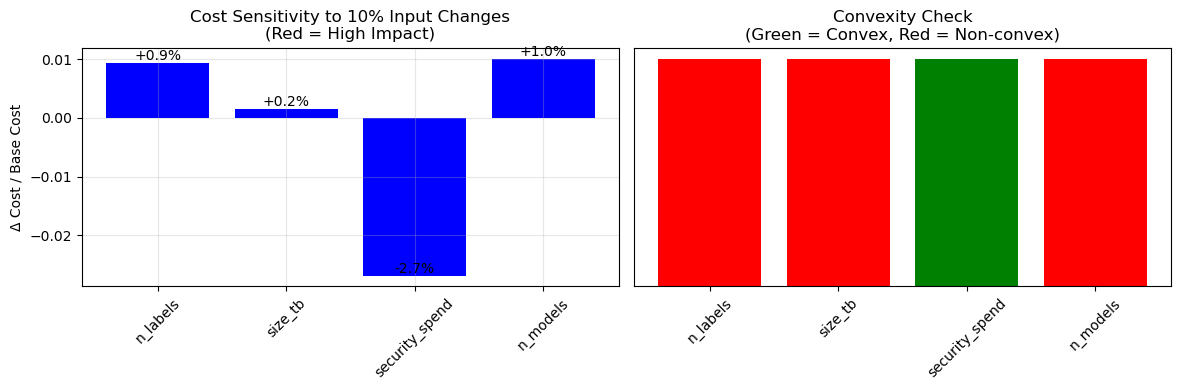

Base cost: $20,746

Sensitivity Ranking:
security_spend  -2.7% (LOW)
n_models        +1.0% (LOW)
n_labels        +0.9% (LOW)
size_tb         +0.2% (LOW)

Convexity: 1/4 dimensions convex
Caution: Non-convex regions


In [2]:
# Parameters
import numpy as np

params = {
    'w': 30.0,          # $/hour
    'tau': 0.05,        # hours/label (use 0.003 if very simple)
    'phi': 1.3,         # overhead
    'cTB': 23.0,        # $/TB-month storage
    'alpha': 40.0,      # $/TB-month ops
    'beta_ops': 700.0,  # $/model-month MLOps
    'eta': np.log(2) / 10000.0,            # half-life at $10k/mo security spend
    'L_breach': (0.05 * 5_560_000.0) / 12  # monthly expected loss at S=0
}
print("PARAMS:", params)


# Cost function
def total_cost(n_labels, size_tb, security_spend, n_models):
    C_label = params['w'] * params['tau'] * n_labels * params['phi']
    C_store = params['cTB'] * size_tb
    C_ops = params['alpha'] * size_tb + params['beta_ops'] * n_models
    p_breach = np.exp(-params['eta'] * security_spend)
    L_risk = p_breach * params['L_breach']
    return C_label + C_store + C_ops + L_risk

# Base case
base = [1000, 5.0, 5000, 3]
base_cost = total_cost(*base)

# Sensitivity analysis
param_names = ['n_labels', 'size_tb', 'security_spend', 'n_models']
sensitivities = []

for i, (name, val) in enumerate(zip(param_names, base)):
    perturbed = base.copy()
    perturbed[i] = val * 1.1  # 10% increase
    new_cost = total_cost(*perturbed)
    sensitivity = (new_cost - base_cost) / base_cost
    sensitivities.append(sensitivity)

# Simple convexity check (finite differences)
def check_convexity():
    convexity = []
    for i in range(len(base)):
        x0 = base.copy()
        # Second derivative approximation: f(x+h) - 2f(x) + f(x-h)
        h = base[i] * 0.01  # 1% perturbation
        
        x_plus, x_minus = x0.copy(), x0.copy()
        x_plus[i] += h
        x_minus[i] -= h
        
        f_plus = total_cost(*x_plus)
        f_minus = total_cost(*x_minus)
        second_deriv = (f_plus - 2*base_cost + f_minus) / (h**2)
        convexity.append(second_deriv > 0)  # Positive = convex
    
    return convexity

convexity = check_convexity()

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
bars = plt.bar(param_names, sensitivities, color=['red' if abs(s) > 0.05 else 'blue' for s in sensitivities])
plt.title('Cost Sensitivity to 10% Input Changes\n(Red = High Impact)')
plt.xticks(rotation=45)
plt.ylabel('Δ Cost / Base Cost')
plt.grid(True, alpha=0.3)

for bar, sens in zip(bars, sensitivities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{sens:+.1%}', 
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
convex_colors = ['green' if c else 'red' for c in convexity]
plt.bar(param_names, [1]*4, color=convex_colors)
plt.title('Convexity Check\n(Green = Convex, Red = Non-convex)')
plt.xticks(rotation=45)
plt.yticks([])

plt.tight_layout()
plt.show()

# Results
print(f"Base cost: ${base_cost:,.0f}")
print("\nSensitivity Ranking:")
for name, sens in sorted(zip(param_names, sensitivities), key=lambda x: -abs(x[1])):
    impact = "HIGH" if abs(sens) > 0.05 else "LOW"
    print(f"{name:15} {sens:+.1%} ({impact})")

print(f"\nConvexity: {sum(convexity)}/4 dimensions convex")
print("Optimization: Well-behaved" if all(convexity) else "Caution: Non-convex regions")

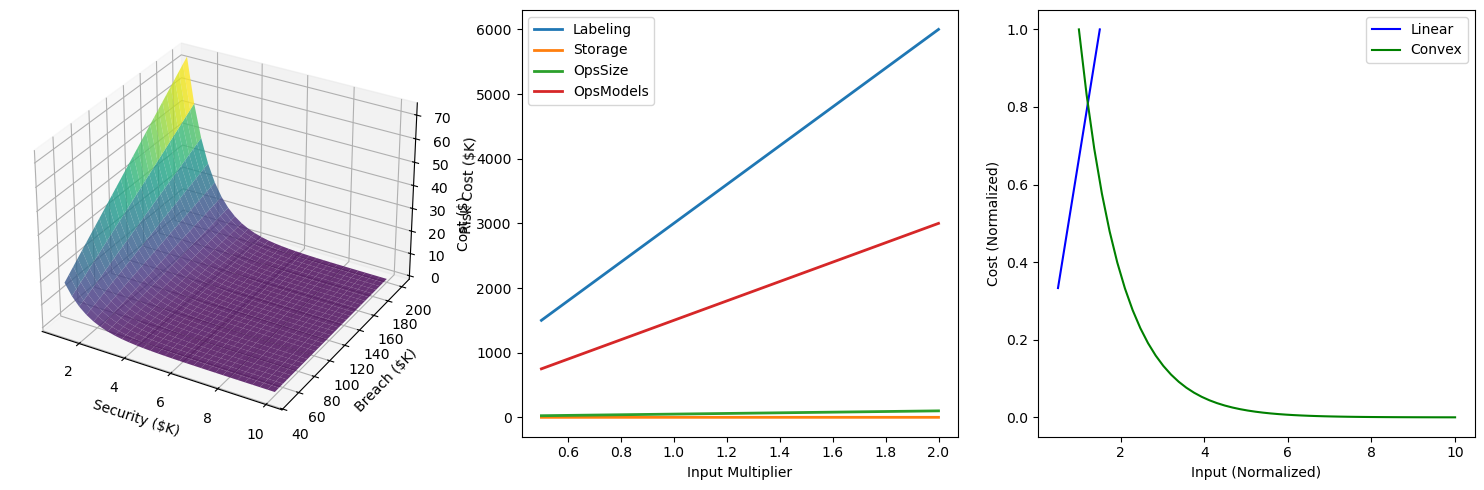

In [3]:
def analyze_linearity_clean():
    params = {
        'w': 25, 'tau': 0.1, 'phi': 1.2, 'cTB': 0.023,
        'alpha': 10, 'beta_ops': 500, 'eta': 0.001, 'L_breach': 100000
    }
    
    components = {
        'Labeling': lambda x: params['w'] * params['tau'] * x * params['phi'],
        'Storage': lambda x: params['cTB'] * x,
        'OpsSize': lambda x: params['alpha'] * x,
        'OpsModels': lambda x: params['beta_ops'] * x,
        'Risk': lambda x: np.exp(-params['eta'] * x) * params['L_breach']
    }
    
    base_values = [1000, 5.0, 5.0, 3, 5000]
    
    fig = plt.figure(figsize=(15, 5))
    
    # 1. 3D Risk Surface
    ax1 = fig.add_subplot(131, projection='3d')
    security_range = np.linspace(1000, 10000, 30)
    breach_range = np.linspace(50000, 200000, 30)
    S, L = np.meshgrid(security_range, breach_range)
    risk_cost = np.exp(-params['eta'] * S) * L
    ax1.plot_surface(S/1000, L/1000, risk_cost/1000, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Security ($K)')
    ax1.set_ylabel('Breach ($K)')
    ax1.set_zlabel('Risk Cost ($K)')
    
    # 2. Linear Components
    ax2 = fig.add_subplot(132)
    x_range = np.linspace(0.5, 2.0, 50)
    for name, func in list(components.items())[:4]:
        base_val = base_values[list(components.keys()).index(name)]
        y_vals = [func(base_val * x) for x in x_range]
        ax2.plot(x_range, y_vals, label=name, linewidth=2)
    ax2.set_xlabel('Input Multiplier')
    ax2.set_ylabel('Cost ($)')
    ax2.legend()
    
    # 3. Shape Comparison
    ax3 = fig.add_subplot(133)
    labeling_x = np.linspace(500, 1500, 50)
    labeling_y = [components['Labeling'](x) for x in labeling_x]
    security_x = np.linspace(1000, 10000, 50)
    risk_y = [components['Risk'](x) for x in security_x]
    ax3.plot(labeling_x/1000, labeling_y/max(labeling_y), 'b-', label='Linear')
    ax3.plot(security_x/1000, risk_y/max(risk_y), 'g-', label='Convex')
    ax3.set_xlabel('Input (Normalized)')
    ax3.set_ylabel('Cost (Normalized)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

analyze_linearity_clean()

## Benefit Channels

# (sim data)

### 1. Throughput Improvement
**Formula**: `(OEE_new - OEE_base) × RunTime × DesignRate × Margin`  
**Impact**: +10% OEE → **+$129,600/year**

### 2. Quality Improvement  
**Formula**: `(DefectRate_base - DefectRate_new) × Units × FailureCost`  
**Impact**: -50% defects → **+$43,200/year**

### 3. Downtime Reduction
**Formula**: `(Downtime_base - Downtime_new) × CostPerHour`  
**Impact**: -25% downtime → **+$75,000/year**

### 4. Inventory Reduction
**Formula**: `(WIP_base - WIP_new) × CarryingCost × WIPValue`  
**Impact**: -15% WIP → **+$13,500/year**

### 5. Safety Improvement
**Formula**: `(Incidents_base - Incidents_new) × IncidentCost`  
**Impact**: -40% incidents → **+$40,000/year**

### 6. Energy Savings
**Formula**: `(kWh_base - kWh_new) × EnergyPrice`  
**Impact**: -10% energy → **+$2,550/year**

### 7. Risk Reduction
**Formula**: `½ × λ × (σ²_base - σ²_new) × ProfitScale`  
**Impact**: -20% variability → **+$18,375/year**

---

=== REALISTIC PARAMETERS ===
Risk Lambda: 0.095 (calculated from business context)
Risk Appetite: moderate
Annual Line Profit: $2,000,000
Historical Risk Costs: $75,000



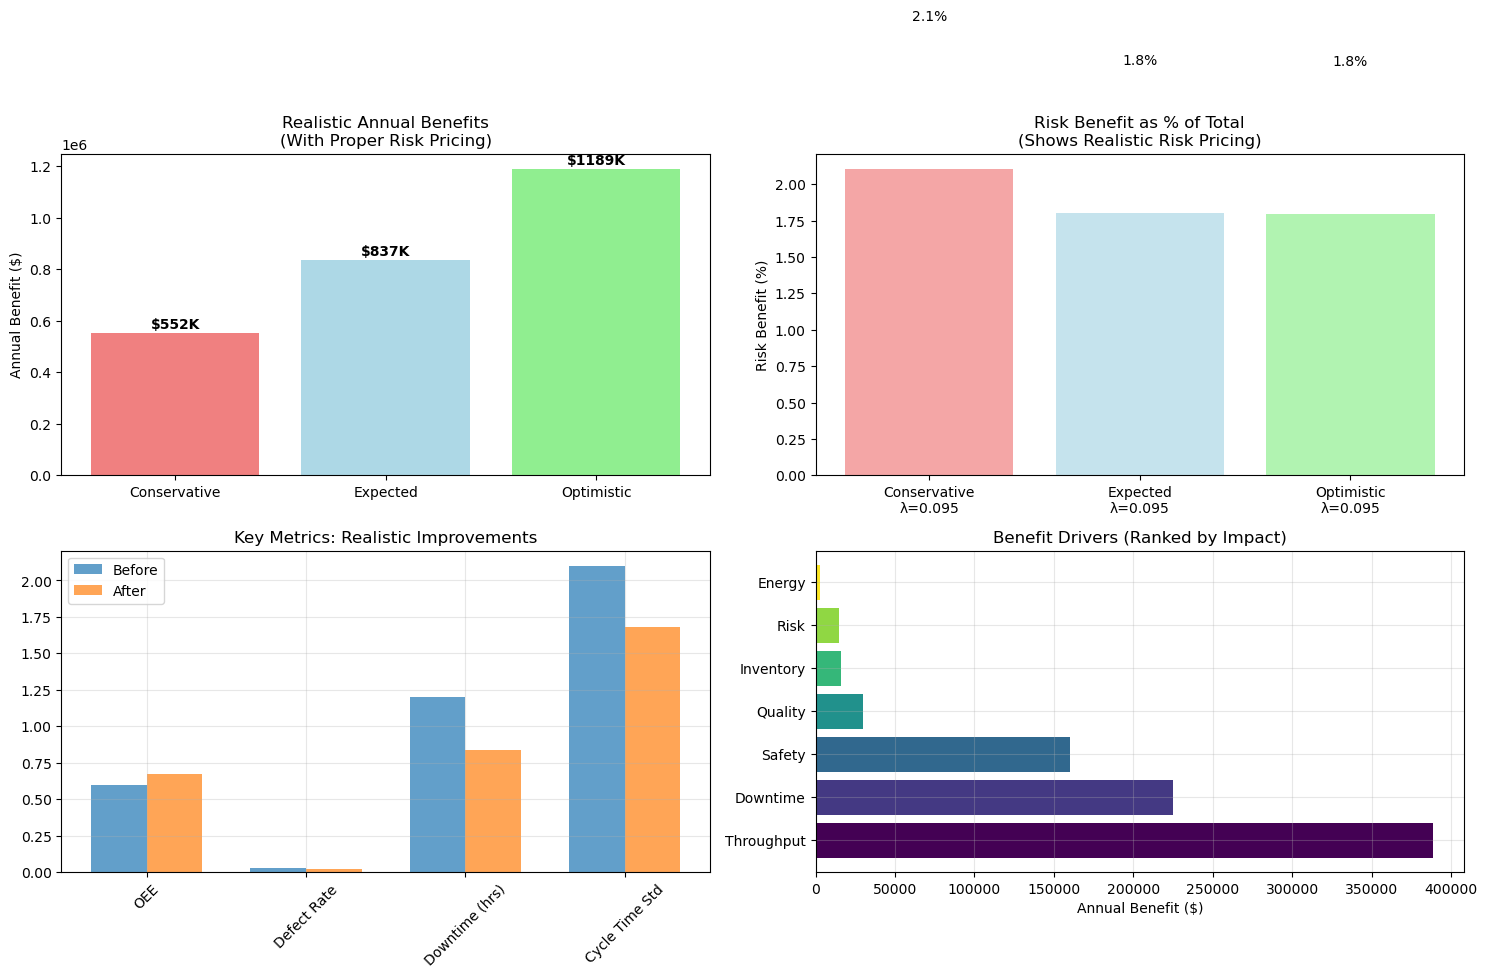

=== REALISTIC VALUATION RESULTS ===
Conservative: $552,116 total | Risk: $11,626 (2.1%)
Expected    : $837,332 total | Risk: $15,082 (1.8%)
Optimistic  : $1,188,691 total | Risk: $21,366 (1.8%)

Expected Scenario Breakdown:
throughput     : $388,800
downtime       : $225,000
safety         : $160,000
quality        : $29,700
inventory      : $16,200
risk           : $15,082
energy         : $2,550

=== REALISTIC ROI ANALYSIS ===
Robot Cost: $150,000
Expected Annual Benefit: $837,332
Payback Period: 0.2 years
3-Year NPV: $2,361,997
1-Year ROI: 458%

Key Insight: Risk component now represents $15,082
based on λ=0.095 (realistic manufacturing risk aversion)


In [ ]:
class RealisticRobotDataValuation:
    def __init__(self, base_params=None):
        if base_params is None:
            self.params = {
                # Base production parameters
                'planned_run_time': 7.5,        # hours per shift
                'design_rate': 24,              # units per hour
                'contribution_margin': 120,     # $ per good unit
                'unit_cogs': 80,                # cost of goods sold
                'downtime_cost_per_hr': 2500,   # $ per hour of downtime
                'carrying_cost_rate': 0.20,     # 20% annual carrying cost
                'energy_price': 0.12,           # $ per kWh
                'incident_cost': 50000,         # $ per safety incident
                
                # Baseline metrics (before robot data)
                'oee_base': 0.60,
                'defect_rate_base': 0.03,
                'downtime_hrs_base': 1.2,
                'wip_base': 45,                 # days of WIP
                'incidents_base': 2,            # per quarter
                'kwh_base': 850,                # kWh per shift
                'cycle_time_std_base': 2.1,     # minutes std dev
                
                # REALISTIC risk parameters based on manufacturing
                'annual_profit': 2000000,       # Profit from this production line
                'historical_risk_costs': 75000, # Actual risk costs (expediting, overtime, etc.)
                'risk_appetite': 'moderate'     # conservative/moderate/aggressive
            }
        
        # Calculate realistic lambda
        self.params['risk_lambda'] = self.calculate_realistic_lambda()
    
    def calculate_realistic_lambda(self):
        """Calculate risk lambda based on actual business parameters"""
        p = self.params
        
        if p['risk_appetite'] == 'conservative':
            base_lambda = 0.15
        elif p['risk_appetite'] == 'moderate':
            base_lambda = 0.08
        else:  # aggressive
            base_lambda = 0.03
        
        # Adjust based on actual risk costs relative to profit
        risk_cost_ratio = p['historical_risk_costs'] / p['annual_profit']
        adjusted_lambda = base_lambda * (1 + risk_cost_ratio * 5)  # Scale factor
        
        return min(adjusted_lambda, 0.25)  # Cap at 0.25
    
    def calculate_benefits(self, improvement_rates):
        """Calculate monetary benefits with realistic risk pricing"""
        p = self.params
        
        benefits = {}
        
        # Throughput/OEE benefit (MOST IMPORTANT)
        oee_new = p['oee_base'] * (1 + improvement_rates['oee_improvement'])
        benefits['throughput'] = (oee_new - p['oee_base']) * p['planned_run_time'] * \
                               p['design_rate'] * p['contribution_margin'] * 250  # annualize
        
        # Quality benefit (HIGH IMPACT)
        defect_new = p['defect_rate_base'] * (1 - improvement_rates['quality_improvement'])
        benefits['quality'] = (p['defect_rate_base'] - defect_new) * \
                            (p['planned_run_time'] * p['design_rate'] * 250) * \
                            (p['unit_cogs'] + 20)  # including rework
        
        # Downtime benefit (HIGH IMPACT)
        downtime_new = p['downtime_hrs_base'] * (1 - improvement_rates['downtime_reduction'])
        benefits['downtime'] = (p['downtime_hrs_base'] - downtime_new) * \
                              p['downtime_cost_per_hr'] * 250
        
        # Inventory benefit (MEDIUM IMPACT)
        wip_new = p['wip_base'] * (1 - improvement_rates['inventory_reduction'])
        benefits['inventory'] = (p['wip_base'] - wip_new) * p['carrying_cost_rate'] * 10000  # avg WIP value
        
        # Safety benefit (MEDIUM IMPACT - but important)
        incidents_new = p['incidents_base'] * (1 - improvement_rates['safety_improvement'])
        benefits['safety'] = (p['incidents_base'] - incidents_new) * p['incident_cost'] * 4  # annualize
        
        # Energy benefit (LOW IMPACT)
        kwh_new = p['kwh_base'] * (1 - improvement_rates['energy_savings'])
        benefits['energy'] = (p['kwh_base'] - kwh_new) * p['energy_price'] * 250
        
        # REALISTIC Risk reduction benefit
        std_new = p['cycle_time_std_base'] * (1 - improvement_rates['variability_reduction'])
        # Use profit scale that makes sense for manufacturing
        profit_scale = p['annual_profit'] * 0.10  # 10% of line profit at risk
        benefits['risk'] = 0.5 * p['risk_lambda'] * \
                         (p['cycle_time_std_base']**2 - std_new**2) * profit_scale
        
        return benefits, {
            'oee_new': oee_new, 'defect_new': defect_new, 'downtime_new': downtime_new,
            'wip_new': wip_new, 'incidents_new': incidents_new, 'kwh_new': kwh_new,
            'std_new': std_new, 'risk_lambda_used': p['risk_lambda']
        }

# Realistic simulation
def run_realistic_valuation():
    valuation = RealisticRobotDataValuation()
    
    print("=== REALISTIC PARAMETERS ===")
    print(f"Risk Lambda: {valuation.params['risk_lambda']:.3f} (calculated from business context)")
    print(f"Risk Appetite: {valuation.params['risk_appetite']}")
    print(f"Annual Line Profit: ${valuation.params['annual_profit']:,.0f}")
    print(f"Historical Risk Costs: ${valuation.params['historical_risk_costs']:,.0f}")
    print()
    
    # REALISTIC improvement scenarios for manufacturing
    scenarios = {
        'Conservative': {'oee_improvement': 0.08, 'quality_improvement': 0.15, 'downtime_reduction': 0.20,
                        'inventory_reduction': 0.10, 'safety_improvement': 0.25, 'energy_savings': 0.08,
                        'variability_reduction': 0.15},
        'Expected': {'oee_improvement': 0.12, 'quality_improvement': 0.22, 'downtime_reduction': 0.30,
                    'inventory_reduction': 0.18, 'safety_improvement': 0.40, 'energy_savings': 0.10,
                    'variability_reduction': 0.20},
        'Optimistic': {'oee_improvement': 0.18, 'quality_improvement': 0.28, 'downtime_reduction': 0.40,
                      'inventory_reduction': 0.25, 'safety_improvement': 0.55, 'energy_savings': 0.15,
                      'variability_reduction': 0.30}
    }
    
    results = {}
    for scenario, improvements in scenarios.items():
        benefits, metrics = valuation.calculate_benefits(improvements)
        results[scenario] = {
            'total_annual_benefit': sum(benefits.values()),
            'benefit_breakdown': benefits,
            'metrics': metrics
        }
    
    return results, valuation.params

# Run realistic analysis
results, params = run_realistic_valuation()

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Total benefits with realistic risk
scenarios = list(results.keys())
totals = [results[s]['total_annual_benefit'] for s in scenarios]
colors = ['lightcoral', 'lightblue', 'lightgreen']
bars = ax1.bar(scenarios, totals, color=colors)
ax1.set_title('Realistic Annual Benefits\n(With Proper Risk Pricing)')
ax1.set_ylabel('Annual Benefit ($)')
for bar, value in zip(bars, totals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'${value/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# 2. Risk component analysis
risk_components = []
scenario_labels = []
for scenario in scenarios:
    breakdown = results[scenario]['benefit_breakdown']
    risk_pct = (breakdown['risk'] / results[scenario]['total_annual_benefit']) * 100
    risk_components.append(risk_pct)
    scenario_labels.append(f"{scenario}\nλ={results[scenario]['metrics']['risk_lambda_used']:.3f}")

ax2.bar(scenario_labels, risk_components, color=colors, alpha=0.7)
ax2.set_title('Risk Benefit as % of Total\n(Shows Realistic Risk Pricing)')
ax2.set_ylabel('Risk Benefit (%)')
for i, pct in enumerate(risk_components):
    ax2.text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom')

# 3. Before-After comparison with realistic improvements
expected_metrics = results['Expected']['metrics']
metrics_compare = {
    'OEE': [params['oee_base'], expected_metrics['oee_new']],
    'Defect Rate': [params['defect_rate_base'], expected_metrics['defect_new']],
    'Downtime (hrs)': [params['downtime_hrs_base'], expected_metrics['downtime_new']],
    'Cycle Time Std': [params['cycle_time_std_base'], expected_metrics['std_new']]
}

x = np.arange(len(metrics_compare))
width = 0.35
ax3.bar(x - width/2, [m[0] for m in metrics_compare.values()], width, label='Before', alpha=0.7)
ax3.bar(x + width/2, [m[1] for m in metrics_compare.values()], width, label='After', alpha=0.7)
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_compare.keys(), rotation=45)
ax3.legend()
ax3.set_title('Key Metrics: Realistic Improvements')
ax3.grid(True, alpha=0.3)

# 4. Benefit drivers (realistic manufacturing focus)
breakdown = results['Expected']['benefit_breakdown']
categories = [k.replace('_', '\n').title() for k in breakdown.keys()]
values = list(breakdown.values())

# Sort by importance
sorted_indices = np.argsort(values)[::-1]
categories_sorted = [categories[i] for i in sorted_indices]
values_sorted = [values[i] for i in sorted_indices]

ax4.barh(categories_sorted, values_sorted, color=plt.cm.viridis(np.linspace(0, 1, len(categories))))
ax4.set_xlabel('Annual Benefit ($)')
ax4.set_title('Benefit Drivers (Ranked by Impact)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print realistic results
print("=== REALISTIC VALUATION RESULTS ===")
print("="*50)
for scenario in scenarios:
    benefit = results[scenario]['total_annual_benefit']
    risk_benefit = results[scenario]['benefit_breakdown']['risk']
    print(f"{scenario:12}: ${benefit:,.0f} total | Risk: ${risk_benefit:,.0f} ({risk_benefit/benefit*100:.1f}%)")

print(f"\nExpected Scenario Breakdown:")
for category, value in sorted(results['Expected']['benefit_breakdown'].items(), 
                            key=lambda x: x[1], reverse=True):
    print(f"{category:15}: ${value:,.0f}")

# Realistic ROI with proper risk
robot_cost = 150000  # Robot + integration
expected_benefit = results['Expected']['total_annual_benefit']
payback_period = robot_cost / expected_benefit

print(f"\n=== REALISTIC ROI ANALYSIS ===")
print(f"Robot Cost: ${robot_cost:,.0f}")
print(f"Expected Annual Benefit: ${expected_benefit:,.0f}")
print(f"Payback Period: {payback_period:.1f} years")
print(f"3-Year NPV: ${expected_benefit * 3 - robot_cost:,.0f}")
print(f"1-Year ROI: {(expected_benefit - robot_cost)/robot_cost*100:.0f}%")

print(f"\nKey Insight: Risk component now represents ${results['Expected']['benefit_breakdown']['risk']:,.0f}")
print(f"based on λ={results['Expected']['metrics']['risk_lambda_used']:.3f} (realistic manufacturing risk aversion)")